In [1]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import PredefinedSplit
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import pickle
from model_pipeline import get_train_test, MissingValueTransformer, \
    CreateFeaturesTransformer
import matplotlib.pyplot as plt

In [2]:
# Constants
RANDOM_STATE = 42
VALIDATION_PORTION = 0.2
FEATURES = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 
            'PT08.S5(O3)', 'T', 'RH', 'AH']
TARGET = ['NMHC(GT)', 'CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

In [12]:
def load_trainset(file_path):
    # Placeholder function to load training data
    # Replace with actual data loading logic
    trainset = pickle.load(open(file_path, 'rb'))
    X_train = trainset['X_train']
    Y_train = trainset['Y_train']
    return X_train, Y_train

def load_testset(file_path):
    # Placeholder function to load test data
    # Replace with actual data loading logic
    testset = pickle.load(open(file_path, 'rb'))
    X_test = testset['X_test']
    Y_test = testset['Y_test']
    return X_test, Y_test

In [3]:
train_dataset, test_dataset = get_train_test()

In [4]:
'''
Define neural network model using PyTorch
'''

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lr=1e-3, hidden=64, epochs=20, dropout=0.2, device=None):
        self.lr = lr
        self.hidden = hidden
        self.epochs = epochs
        self.model = None
        self.dropout = dropout

        # 自动选择设备
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.train_loss_curve_ = []

    
    def _build_model(self, input_dim, output_dim=1):
        return nn.Sequential(
            nn.Linear(input_dim, self.hidden),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden, output_dim)
        ).to(self.device)
    

    def fit(self, X, Y):
        # numpy → tensor，并放到 GPU
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        Y = torch.tensor(Y, dtype=torch.float32).view(-1, Y.shape[1]).to(self.device)

        self.model = self._build_model(X.shape[1], output_dim=Y.shape[1])
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        for _ in range(self.epochs):
            optimizer.zero_grad()
            pred = self.model(X)
            loss = criterion(pred, Y)
            loss.backward()
            optimizer.step()

            self.train_loss_curve_.append(loss.item())
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        self.model.eval()
        with torch.no_grad():
            pred = self.model(X).cpu().numpy() # 🔥 输出转回 CPU numpy
        return pred

In [5]:
def select_non_nan_rows(X, Y):
    mask = Y.notna().all(axis=1) & X.notna().all(axis=1)
    return X[mask], Y[mask]

def preprocess_data(train_dataset, test_dataset, target_col):
    col = target_col

    X_train, Y_train = train_dataset[FEATURES], train_dataset[[col]]  # Drop NaN in target for training set
    X_test, Y_test = test_dataset[FEATURES], test_dataset[[col]]  # Drop NaN in target for test set

    data_preprocessing_pipeline = Pipeline(steps=[
        ('missing', MissingValueTransformer()),
        ('features', CreateFeaturesTransformer(lags=[1,3,6,12,24], window_sizes=[3,6,12])),
    ])

    X_train = data_preprocessing_pipeline.fit_transform(X_train)
    X_test = data_preprocessing_pipeline.transform(X_test)
    X_train, Y_train = select_non_nan_rows(X_train, Y_train)
    X_test, Y_test = select_non_nan_rows(X_test, Y_test)
    return X_train, Y_train, X_test, Y_test

In [6]:
X_train, Y_train, X_test, Y_test = preprocess_data(train_dataset, test_dataset, 'CO(GT)')

In [18]:
from plot_functions import plot_scatter_each_column_rolling
import pandas as pd

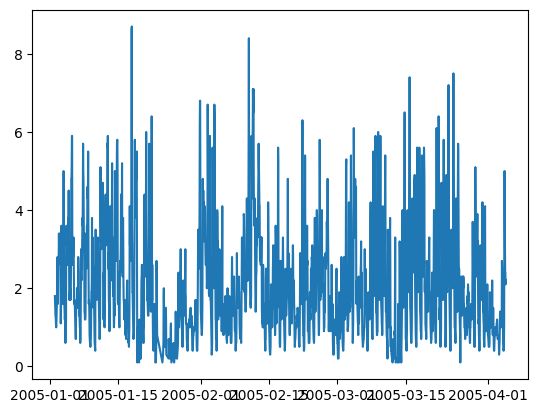

In [12]:
plt.plot(Y_test)

In [13]:
X_train, Y_train, X_test, Y_test = preprocess_data(train_dataset, test_dataset, 'CO(GT)')
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train)
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
Y_test = scaler_Y.transform(Y_test)

loss_history = []
def record_loss(res):
    # res.fun 就是当前最佳 loss（你的 scoring 是 negative RMSE）
    loss_history.append(res.fun)

model = TorchRegressor()

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),  
    ('model', model)
])

hyperspace = {
    "model__lr": Real(1e-6, 1e-1, prior="log-uniform"),
    "model__hidden": Integer(128, 256),
    "model__epochs": Categorical([60]),
    "model__dropout": Real(0.1, 0.3)
}

ps = PredefinedSplit(
    test_fold=np.concatenate([
        -np.ones(int(len(X_train)*(1-VALIDATION_PORTION))),   # train
        np.zeros(int(len(X_train)*VALIDATION_PORTION))        # validation
    ])
)

opt = BayesSearchCV(
    estimator=pipeline,  
    search_spaces=hyperspace,
    cv=ps,
    n_iter=32,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    scoring='neg_root_mean_squared_error'
)
opt.fit(X_train, Y_train, callback=[record_loss])

best_model = opt.best_estimator_
best_params = opt.best_params_

Y_pred = best_model.predict(X_test)
Y_pred = scaler_Y.inverse_transform(Y_pred)
nn_metrics = {}
nn_metrics['rmse'] = np.sqrt(np.mean((Y_pred - Y_test)**2))

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

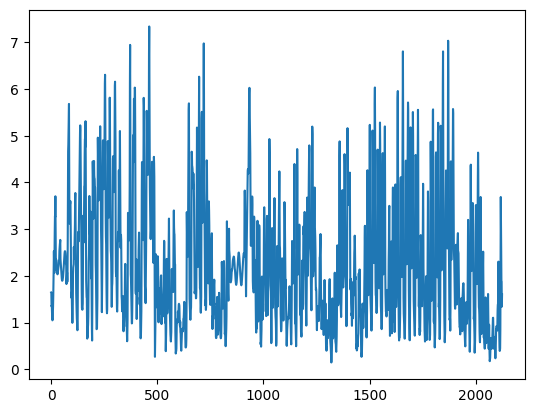

In [14]:
plt.plot(Y_pred)

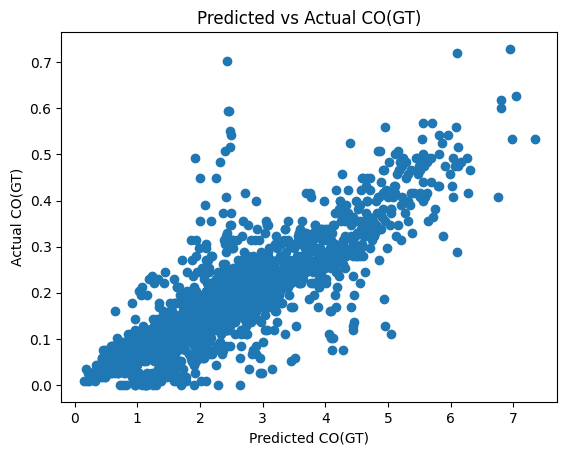

In [15]:
plt.scatter(Y_pred, Y_test)
plt.xlabel("Predicted CO(GT)")
plt.ylabel("Actual CO(GT)")
plt.title("Predicted vs Actual CO(GT)")
plt.show()

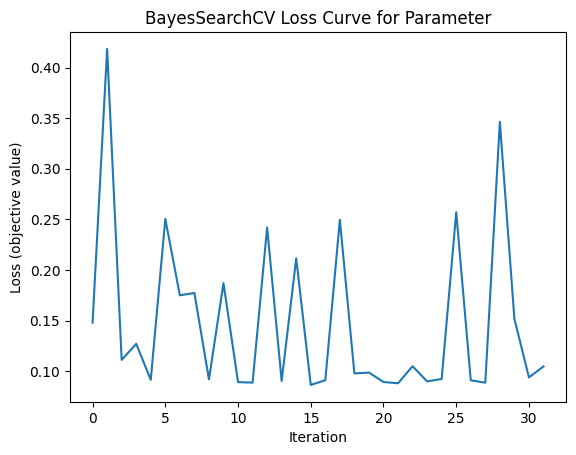

In [16]:
res = opt.optimizer_results_[0]    # 第一个空间的优化结果

plt.plot(res.func_vals)
plt.xlabel("Iteration")
plt.ylabel("Loss (objective value)")
plt.title(f"BayesSearchCV Loss Curve for Parameter")
plt.show()

In [18]:
nn_metrics['rmse']

np.float64(2.38872697736499)

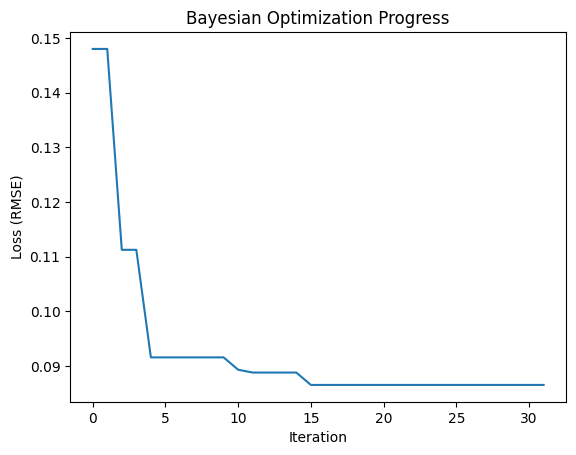

In [19]:
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss (RMSE)")
plt.title("Bayesian Optimization Progress")
plt.show()

In [20]:
best = opt.best_params_

best_model = TorchRegressor(
    lr = best["model__lr"],
    hidden = best["model__hidden"],
    epochs = best["model__epochs"],
    dropout = best["model__dropout"],
    device = 'cuda'
)

best_model.fit(X_train, Y_train)

,lr,0.0006204420289117527
,hidden,256
,epochs,60
,dropout,0.1
,device,'cuda'


In [26]:
best

OrderedDict([('model__dropout', 0.1),
             ('model__epochs', 60),
             ('model__hidden', 256),
             ('model__lr', 0.0006204420289117527)])

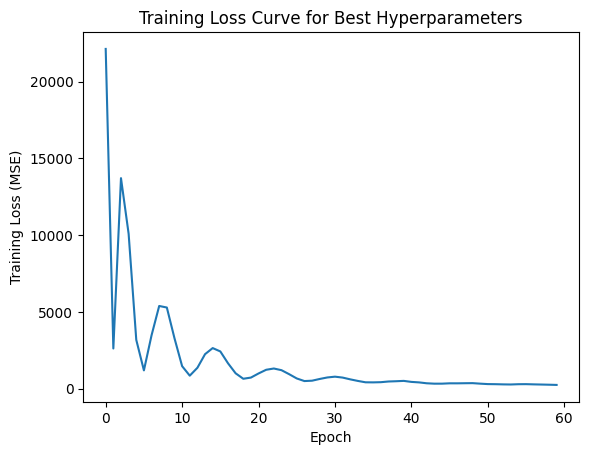

In [21]:
plt.plot(best_model.train_loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss Curve for Best Hyperparameters")
plt.show()

In [24]:
from sklearn.linear_model import LinearRegression

X_train, Y_train, X_test, Y_test = preprocess_data(train_dataset, test_dataset, 'CO(GT)')
X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train)
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()
Y_test = scaler_Y.transform(Y_test)

loss_history = []
def record_loss(res):
    # res.fun 就是当前最佳 loss（你的 scoring 是 negative RMSE）
    loss_history.append(res.fun)

model = LinearRegression()

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),  
    ('model', model)
])

hyperspace = {
    # LinearRegression has no hyperparameters to tune in this context
    "model__fit_intercept": Categorical([True])
}

ps = PredefinedSplit(
    test_fold=np.concatenate([
        -np.ones(int(len(X_train)*(1-VALIDATION_PORTION))),   # train
        np.zeros(int(len(X_train)*VALIDATION_PORTION))        # validation
    ])
)

opt = BayesSearchCV(
    estimator=pipeline,  
    search_spaces=hyperspace,
    cv=ps,
    n_iter=1,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    scoring='neg_root_mean_squared_error'
)
opt.fit(X_train, Y_train, callback=[record_loss])

best_model = opt.best_estimator_
best_params = opt.best_params_

Y_pred = best_model.predict(X_test)
Y_pred = scaler_Y.inverse_transform(Y_pred)
metrics = {}
metrics['rmse'] = np.sqrt(np.mean((Y_pred - Y_test)**2))

Fitting 1 folds for each of 1 candidates, totalling 1 fits


In [25]:
metrics['rmse']

np.float64(2.1598615653629385)